In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, solve_continuous_are
import math

# the library requires "optional" dependencies not available in pip for almost all basic functions, 
# but plotting for zonotopes with a small amount of generators works fine.
# Plotting Zonotopes is the only intended use in the tutorial!
# https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.488.5151&rep=rep1&type=pdf
!pip install pypolycontain
import pypolycontain as pp 

# shapely is used for collision checking. It might not necessarily refer to zonotopes
# but we can always transfer
# https://shapely.readthedocs.io/en/stable/manual.html
from shapely.geometry import box, Polygon, MultiPoint

# for the animations
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/pypolycontain/operations.py:23: UserWarning: You don't have pydrake installed properly. Methods that rely on optimization may fail.
  warnings.warn("You don't have pydrake installed properly. Methods that rely on optimization may fail.")
/usr/local/lib/python3.7/dist-packages/pypolycontain/conversions.py:19: UserWarning: WARNING: You don't have CDD package installed. Unable to visualize polytopes. You may still visualize zonotopes.
  warnings.warn("WARNING: You don't have CDD package installed. Unable to visualize polytopes. You may still visualize zonotopes.")
/usr/local/lib/python3.7/dist-packages/pypolycontain/conversions.py:32: UserWarning: You don't have pydrake installed properly. Methods that rely on optimization may fail.
  warnings.warn("You don't have pydrake installed properly. Methods that rely on optimization may fail.")
/usr/local/lib/python3.7/dist-packages/pypolycontain/conversions.py:38: UserWarning: You don't have pydrake with SC

# Safe Autonomy Tutorial: Reachability and object detection using zonotopes

In this part of the tutorial, we will apply the findings of the previous tutorial to a collision-avoidance scenario! Given that we can now compute the permissible space of an autonomous system of the form 

$ \dot{x}(t) = A x(t) + d(t) $

were $d(t)$ is a bounded disturbance (in the previous tutorial $u(t)$), we can check the check the collision of two systems when propagated through time. 
As such, we will subject a nominally stable object and a controllable 'robot' of the form

$ \dot{x}(t) = A x(t) + B u(t) + d(t)$

to a zonotope collision check. We will use LQR to stabilize the system subjected to our preferences!

# The Object 
We consider a moving obstacle which might cause issues for the robot's planned trajectory. We consider the obstacle as a first order integrator system with an uncertain initial position. What we do know is that the $x$ and $y$ coordinate of the system are normally distributed according to

$x_0 \sim \mathcal{N}(2.5,0.05)$

$y_0 \sim \mathcal{N}(-3.5,0.055)$

We will first prescribe a zonotope with 2 generators that most closely describes this multivariate Gaussian distribution in the 2 dimensional plane at a confidence interval of 90%.

First, describe the two dimensional Gaussian distribution as an ellipse.

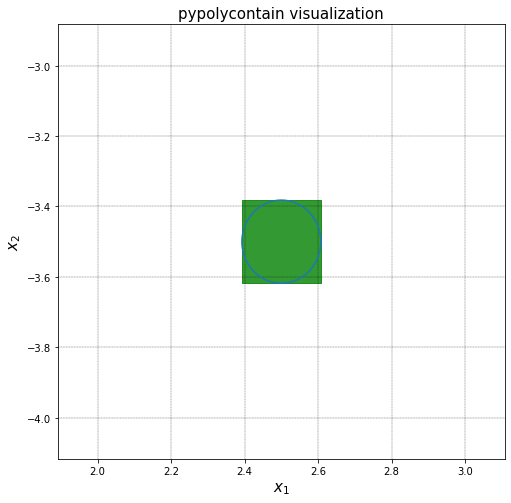

In [2]:
# hint: #https://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix/
Sigma = np.array([[0.05, 0], [0, 0.055]])
Mu = np.array([2.5, -3.5])
# round the chi^2 value for this scenario to two decimals!
# https://people.richland.edu/james/lecture/m170/tbl-chi.html
s = 4.61 # the chi^2 value
major_axis = 2 * Sigma[0,0] * np.sqrt(s) # 0.96
minor_axis = 2 * Sigma[1,1] * np.sqrt(s) # 1.01
c0 = Mu
g0 = np.array([[0.5*major_axis, 0], [0, 0.5*minor_axis]])
z0 = pp.zonotope(x=c0, G=g0)

# some plotting
fig, ax = plt.subplots()

t = np.linspace(0, 2*math.pi, 100)
ax.plot(Mu[0]+0.5*major_axis*np.cos(t), Mu[1]+0.5*minor_axis*np.sin(t))
pp.visualize([z0], ax=ax, fig=fig)

Now, let's take a step back and first generalize the results from the previous part into a function. Given some input data (see below), we want a function that returns the list of zonotopes. 

This mostly involves using the code from the previous part and turning it into a function.

In [3]:
def get_zonotopes(A,mu,c0,g0,t,r,color='g',simplify=False):
    # where
    # A: system matrix
    # mu: bounded disturbance
    # c0: initial condition
    # g0: initial generators
    # t: total simulation time
    # r: duration of time-step
    # color: the color of the zonotopes, helps distinguishing later on
    # simplify: do we lower the order of the zonotopes? (already with 2 generators so not always necessary)

    n = int(t / r)    # amount of time steps

    # initial zonotope
    if simplify:
        g0 = np.array([[np.sum(np.abs(g0[0])), 0], [0, np.sum(np.abs(g0[1]))]])
    init_zt = pp.zonotope(x=c0, G=g0)
    init_zt.color = color

    # derived constants from pseudo code
    A_norm = np.linalg.norm(A, np.inf)
    e_ra = np.array(expm(r*A))

    sup_ig = max(np.linalg.norm(g, np.inf) for g in g0.T)      # iterate over columns, which are the generators of the initial zonotope
    alpha = (np.exp(r*A_norm) - 1 - r*A_norm) * sup_ig
    beta = ((np.exp(r*A_norm) - 1) / A_norm) * mu

    beta_box_g = np.array([[beta, 0], [0, beta]]).reshape(2, 2)
    alpha_beta_box_g = np.array([[alpha+beta, 0], [0, alpha+beta]]).reshape(2, 2)

    # p0 computations - center vector
    p0_c = (c0 + e_ra @ c0) / 2

    # p0 computations - generators
    p0_g_part_1 = (g0 + e_ra @ g0) / 2
    p0_g_part_2 = (c0 - e_ra @ c0) / 2
    p0_g_part_2 = p0_g_part_2[..., np.newaxis]
    p0_g_part_3 = (g0 - e_ra @ g0) / 2
    p0_g = np.hstack((p0_g_part_1, p0_g_part_2, p0_g_part_3))

    # q0 computations
    q0_c = p0_c # alpha_beta_box has center 0
    q0_g = np.append(p0_g, alpha_beta_box_g, axis=1)

    # lists to store the q generators and centers
    q_g = []
    q_c = []
    q_c.append(q0_c)
    q_g.append(q0_g)

    # loop to compute pi and qi from predecessors
    for i in range(1, n):
        pi_c = e_ra @ q_c[-1]
        pi_g = e_ra @ q_g[-1]

        qi_c = pi_c
        qi_g = np.append(pi_g, beta_box_g, axis=1)

        q_c.append(qi_c)
        q_g.append(qi_g)

    # create list of (simplified) zonotopes
    zts = []  # we will use this to store our results
    zts.append(init_zt)   
    for i in range(n):
        # reduction step by interval hull
        qi_g_reduced = np.zeros((2, 2))
        for index, row in enumerate(q_g[i]):
            qi_g_reduced[index, index] = np.sum(np.abs(row))
        # add the reduced zonotope to the zonotope list
        zts.append(pp.zonotope(x=q_c[i], G=qi_g_reduced))
        zts[-1].color = color

    return zts # return the zonotopes

Now let's call the function for the object and visualize our nominally stable trajectory! 

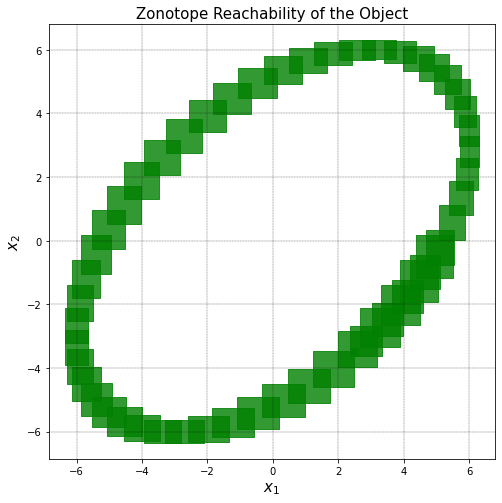

In [4]:
# duration of simulation
sim_duration = 4
r = 0.075
Ac = np.array([[1,-2],[2, -1]])
mu = 0.02

#c0 = 
#g0 = 

zts_obj = get_zonotopes(Ac,mu,c0,g0,sim_duration,r,color='g')
fig, ax = plt.subplots()
pp.visualize(zts_obj, title='Zonotope Reachability of the Object', fig=fig, ax=ax)
plt.show()

# The Robot!
Our robot model is given by a similar 2D single-integrator system. As mentioned, this is of the form

$ \dot{x}(t) = A x(t) + B u(t) + d(t)$

$ \begin{bmatrix} \dot{x} \\ \dot{y} \end{bmatrix} = \begin{bmatrix} -1 & 1 \\ -1 & 1 \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix} + \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} \begin{bmatrix} u_x \\ u_y \end{bmatrix} + d(t)$

which can be written in the desired autonomous form when a state-feedback control policy is applied. Our state-feedback will be obtained via [LQR](https://en.wikipedia.org/wiki/Linear%E2%80%93quadratic_regulator) which gives us an appropriate state-feedback controller given certain weights on the state deviation and the control input.

For our purposes, we wish to penalize both state-deviation and control input equally in the vertical and horizontal plane. In all situations, we do not penalize any cross-terms. For the state-deviation, we consider a weight of $50$ and for the control input a weight of $5$ respectively.

Below, implement the system and weight matrices and obtain the LQR closed-loop stabilized system by solving the continuous-time algebraic Ricatti equation using the `scipy` package. We then plot the zonotopes of the object and the robot in a single plot (use the color argument in your `get_zonotopes()` function!)

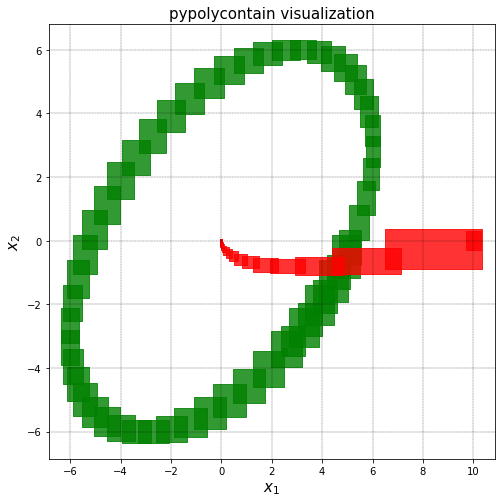

In [5]:
#PUT YOUR CODE HERE
A = np.array([[-1,1],[-1,1]])
B = np.array([[1,0],[0,1]])
Q = np.diag([120,55])
R = np.diag([5,5])
P = solve_continuous_are(A,B,Q,R) # Solves the continuous algebraic Riccati equation defined as (A’X + XA - XBR^-1B’X+Q=0)
K = np.linalg.inv(R) @ (np.transpose(B) @ P) # N = 0

Ac = (A - B @ K) # closed-loop system: x' = Ax + Bu with u = -Kx -> x' = (A - B @ K) x

mu = 0.1
c0 = np.array([10,0])
g0 = np.array([[0.3,0],[0,0.3]])

zts_rob = get_zonotopes(Ac,mu,c0,g0,sim_duration,r,color='r')

fig, ax = plt.subplots()
pp.visualize(np.append(zts_obj,zts_rob), fig=fig, ax=ax)
plt.show()

Here's an animation function which should give you some indication of what is actually going on:

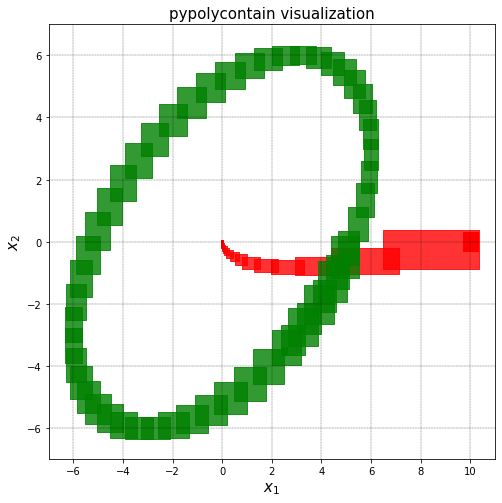

In [6]:
## ANIMATION FUNCTION
def animation_func(i,data):
  zts_obj = data[0]
  zts_rob = data[1]
  pp.visualize([zts_obj[i]], fig=fig, ax=ax)
  pp.visualize([zts_rob[i]], fig=fig, ax=ax)
  ax.set_xlim([-7, 11])
  ax.set_ylim([-7, 7])
  
fig = plt.figure()
ax = fig.add_subplot(111)
animation = FuncAnimation(fig,animation_func, fargs=((zts_obj,zts_rob),),
                          frames=len(zts_obj), interval=50, blit=False)
HTML(animation.to_html5_video())

# Collisions!

Given the fact that we limit ourselves to zonotopes with two generators, we can do a simple collision check on two rectangles. This involves checking overlap with 4 conditions given the center and height and width (or edge points) of the rectangles. 

Implement this very simple rectangle collision checker in a function:

In [7]:
# Returns true if two rectangles(l1, r1) and (l2, r2) overlap (from geeksforgeeks)
# l1: Top Left coordinate of first rectangle. 
# r1: Bottom Right coordinate of first rectangle. 
# l2: Top Left coordinate of second rectangle. 
# r2: Bottom Right coordinate of second rectangle.
def do_overlap(l1, r1, l2, r2):
    # if rectangle has area 0, no overlap
    if l1[0] == r1[0] or l1[1] == r1[1] or r2[0] == l2[0] or l2[1] == r2[1]:
        return False
    # If one rectangle is on left side of other
    if l1[0] > r2[0] or l2[0] > r1[0]:
        return False
    # If one rectangle is above other
    if r1[1] > l2[1] or r2[1] > l1[1]:
        return False
    return True

def simple_collision_check(zts_obj,zts_rob):    
    collision = False
    i = 0
    for zt_obj, zt_rob in zip(zts_obj, zts_rob):
        #collision = smth and smth else and smth else and smth else
        vertices_obj = pp.conversions.zonotope_to_V(zt_obj)
        vertices_rob = pp.conversions.zonotope_to_V(zt_rob)
        #print(vertices_obj)
        if do_overlap(vertices_obj[3], vertices_obj[1], vertices_rob[3], vertices_rob[1]):
            print(f"Collision of the {i}. zonotope!")
            return True
        i = i + 1
    print("No collisions!")
    return False

simple_collision_check(zts_obj,zts_rob)

No collisions!


False

However, this does not generalize to zonotopes with many more generators. A given is that regardless of how many generators a zonotope has, the shape is always convex! As such, we can check the collision via intersection of two convex polytopes which we will construct using shapely.geometry.Polygon.

We could of course check intersection by methods that explicitly rely on zonotopes (e.g. [this](https://graphics.stanford.edu/~anguyen/papers/zonotope.pdf)). You're free to implement these methods, yet using the shapely library suffices for now. We are going to use it later on as well.

Implement this more general collision checker in a function:

In [8]:
def polygon_collision_check(zts_obj,zts_rob):
    collision = False
    i = 0
    for zt_obj, zt_rob in zip(zts_obj, zts_rob):
        # 1: get the vertices from the zonotope
        vertices_obj = pp.conversions.zonotope_to_V(zt_obj)
        vertices_rob = pp.conversions.zonotope_to_V(zt_rob)

        # 2: convert the vertices into a shapely Polygon
        vertices_obj_list = [tuple(i) for i in vertices_obj]
        vertices_rob_list = [tuple(i) for i in vertices_rob]
        polygon_obj = Polygon(vertices_obj_list)
        polygon_rob = Polygon(vertices_rob_list)

        # 3: check if polygons intersect/collide
        if polygon_rob.intersects(polygon_obj):
            print(f"Collision of the {i}. polygon!")
            return True
        i = i + 1
    print("No collisions!")
    return False

# print whether a collision occured or not
polygon_collision_check(zts_obj,zts_rob)

No collisions!


False

Seems like we're not in collision then! However, we are currently having a severe oversight (you might have already noticed it yourself!). Due to the time-discretization, we are checking collisions at distinct instances in time. Whatever happens inbetween these instances, we do not know or consider!

A straightforward, yet conservative, solution to this is to check collision for the convex hulls of the robot and the object of two discrete instances of time. Although we could use an off-the-shelf algorithm to find the convex hull of a set of points (originating from the points of the vertices of the two zonotopes), where's the fun in that? 

Instead, in this part, we will create our own convex-hull algorithm that returns a convex `shapely` polygon of a given set of points! A good starting point, and quite a straight-forward algorithm is the `Graham's scan algorithm`. Feel free, however, to use any algorithm you want! As long as it returns a convex `shapely` polygon!

In [9]:
def gift_wrapping(pts):
    '''
    Calculates convex hull according to the gift wrapping algorithm.
    See here: https://en.wikipedia.org/wiki/Gift_wrapping_algorithm
    pts: numpy array storing the points of the polygon. Each point is
         represented by a numpy array with two elements.
    '''
    # Computes the cross product of vectors p1p2 and p1p3 (i.e., p1p2 x p1p3).
    # Positive if the angle from p1p2 tp p1p3 is positive, i.e. p3 is left of p1p2.
    def cross(p1, p2, p3):
        return (p2[0] - p1[0]) * (p3[1] - p1[1]) - (p2[1] - p1[1]) * (p3[0] - p1[0])

    point_on_hull = min(pts, key=lambda p: p[0]) # leftmost point in S which is guaranteed to be part of the convex hull of pts
    pts_of_polygon = []
    while True:
        pts_of_polygon.append(tuple(point_on_hull))
        endpoint = pts[0] # initial endpoint for a candidate edge on the hull
        for point in pts:
            # endpoint == pointOnHull is a rare case and can happen only when j == 1 and a better endpoint has not yet been set for the loop
            # other statement checks if point is on left of line from point_on_hull to endpoint
            if np.array_equal(endpoint, point_on_hull) or (cross(point_on_hull, endpoint, point) > 0):
                endpoint = point # found greater left turn, update endpoint
        point_on_hull = endpoint
        if np.array_equal(endpoint, pts_of_polygon[0]): # wrapped around to first hull point
            break
    return Polygon(pts_of_polygon)


# def graham_scan(pts): #(or whatever algorithm you want!)
#     #PUT YOUR CODE HERE
#     pts_of_polygon =
#     pts_sorted = 
  
#     return Polygon([[v[0],v[1]] for v in pts_of_polygon]), pts_sorted

# where pts_sorted is all the points sorted before applying the left-turn, 
# right-turn check. This might help you with debugging purposes and allows you 
# to directly use the example below:

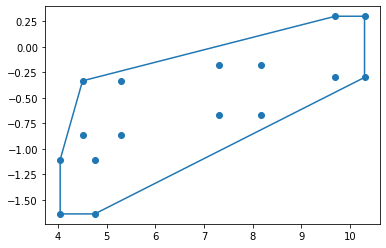

In [10]:
pts = np.array([[ 9.7       , -0.3       ],
                [10.3       , -0.3       ],
                [10.3       ,  0.3       ],
                [ 9.7       ,  0.3       ],
                [ 7.3019237 , -0.67042288],
                [ 8.17008638, -0.67042288],
                [ 8.17008638, -0.17500955],
                [ 7.3019237 , -0.17500955],
                [ 4.04093198, -1.63931786],
                [ 4.7517695 , -1.63931786],
                [ 4.7517695 , -1.10690099],
                [ 4.04093198, -1.10690099],
                [ 4.5013919 , -0.86892737],
                [ 5.28560014, -0.86892737],
                [ 5.28560014, -0.33356628],
                [ 4.5013919 , -0.33356628]])

# pts = np.array([[10, 0],
#                 [9, 1],
#                 [6, -3],
#                 [4, 2],
#                 [7, 6]])

poly = gift_wrapping(pts)
plt.scatter(pts[:,0], pts[:,1])
plt.plot(*poly.exterior.xy)
plt.show()

#poly,pts_sorted = gift_wrapping(pts)
# plt.scatter(pts_sorted[:,0],pts_sorted[:,1])
# for i in range(0,len(pts_sorted)):
#     plt.annotate(i,(pts_sorted[i,0],pts_sorted[i,1]))
# plt.plot(*poly.exterior.xy)
# plt.show()

# feel free to use whatever algorithm you want. You might not obtain a sorted
# sequence of points, so you might need to change the example a bit. pts_sorted
# is not used in the remainder of this tutorial! A requirement is that you
# code the algorithm yourself!!! Have a look at 
# https://en.wikipedia.org/wiki/Convex_hull_algorithms

Implement this in a collision checker function:

an additional requirement: plot the convex hulls in a figure, until a collision is detected!

True

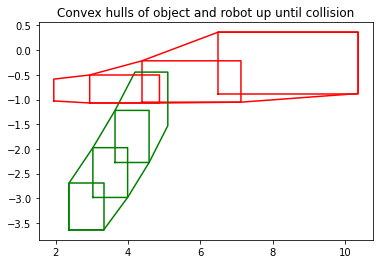

In [11]:
def convex_hull_collision_check(zts_obj,zts_rob):
    plt.figure()
    plt.title("Convex hulls of object and robot up until collision")
    for i in range(0, len(zts_obj)-1):
        # 1: get the points of two instances of the object
        vertices_obj = np.vstack((pp.conversions.zonotope_to_V(zts_obj[i]), pp.conversions.zonotope_to_V(zts_obj[i+1])))
        vertices_rob = np.vstack((pp.conversions.zonotope_to_V(zts_rob[i]), pp.conversions.zonotope_to_V(zts_rob[i+1])))

        # 2: construct a convex polytope from that using the function from the previous exercise
        ply_obj = gift_wrapping(vertices_obj)
        ply_rob = gift_wrapping(vertices_rob)

        # 3: plot the convex hulls until a collision is detected
        x,y = ply_obj.exterior.coords.xy
        plt.plot(x,y,'g')
        x,y = ply_rob.exterior.coords.xy
        plt.plot(x,y,'r')
        if ply_rob.intersects(ply_obj):
            return True
    return False

convex_hull_collision_check(zts_obj,zts_rob)

Do you get a different answer?

Answer: Yes, now a collision is detected!

# Collision! What to do now?
What you have been doing so far is often referred to as $\textit{verification}$ process since you are using the knowledge of your system to analyze whether some desired specification (do not collide with an obstacle) holds or not.

In the next couple of steps, you're gonna look into the so called $\textit{synthesis}$ process in which you are given a desired system specification and you design a control strategy $u$ such that the specification holds. Specifically, you're gonna design different Control Barrier Functions (CBFs) to guarantee that the robot stays within an obstacle-free safeset. CBFs have been covered in the lectures but if you would like to refresh your knowledge you might want to have a look at $\href{https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8796030&casa_token=CtgTXVjMhTAAAAAA:93TomzH638Rg17rJl9LRW5WYljATBuiBor0OkfvSXwvZ-Y0rO-xkOhK15JBWIqrcIDgnqlEX}{this} $ publication.

# Simple yet provably safe controller
First, we will design a very conservative barrier function. In this case, we would like to obtain a halfspace constraint that contains all possible obstacle locations. If we can design a controller that stays within this obstacle-free halfspace, we are guaranteed to avoid collisions.


Such a halfspace can be defined as $\mathcal{H} = \left\{ x \in \mathbb{R}^n \mid a^T x \leq b\right\}$. Recall, that any polygon can also be written as an intersection of halfspaces. Convince yourself that the convex hull of all obstacle location from $t=0, \dots , T$ contains all possible locations the obstacle might be at. In the following, try to find this convex polygon and visualize it!

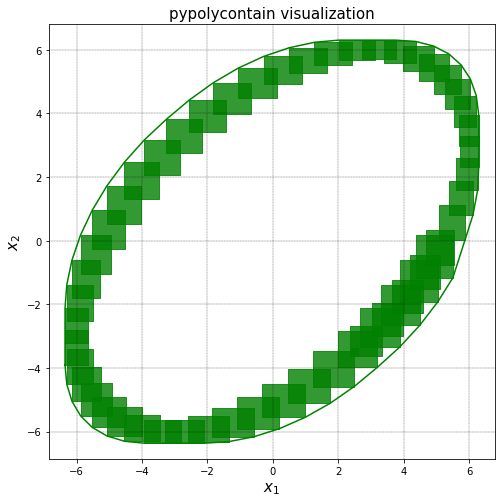

In [12]:
# trajectory of the obstacle in V-form
obj_trajectory = [pp.zonotope_to_V(zts_obj[i]).tolist()[j] for i in range(len(zts_obj)) for j in range(4)]

# convex hull of obstacle trajectory
conv_hull_obj = gift_wrapping(obj_trajectory)

# Visualization
x,y = conv_hull_obj.exterior.coords.xy

pp.visualize(zts_obj)
plt.plot(x,y,'g')
plt.show()

Next, in order to define our barrier function, we need the convex hull of the obstacle trajectory in halfspace form (H-polytope). Unfortunatel, the function provided in `pypolycontain` does not work properly, so we have to do the conversion ourselves. Recall that each edge of the polytope between two consecutive vertices $V_i$ and $V_{i+1}$ can be described as a linear function of the form $a^T x - b = 0$.

Note, that the convex hull has many vertices, so we would like to create a list of tuples that contains all the halfspaces $halfspaces = [(a_0, b_0), \dots, (a_{N-1}, b_{N-1})]$ where $N$ is the number of vertices. Since it can be tideous to find the correct sign of the halfspaces, this function is provided in the following. Try to understand the code!

Notes by Franz: <br />
$y = ax - b = \frac{dy}{dx} x - b$ <br />
$\vec{a}^T \vec{x} - b = a_0 x + a_1 y - b \rightarrow -a_1 y = a_0 x - b$ <br />
With $a_1 = -1$: $y = a_0 x - b \rightarrow a_0 = \frac{dy}{dx}$, $b = a_0 x - y$

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


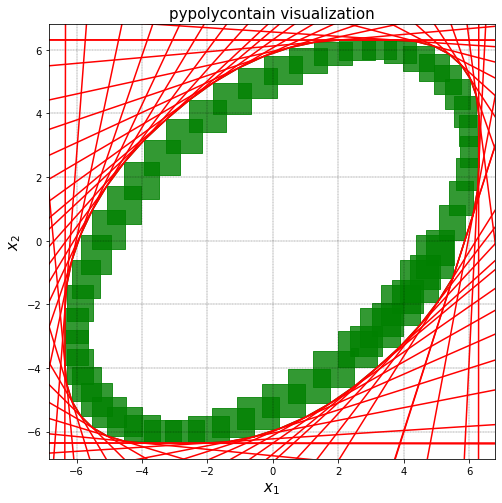

In [13]:
vertices = np.array([[x[i], y[i]] for i in range(len(x))])
vertices = np.flip(vertices, 0) # From Franz: Necesarry because I use a different convex hull algorithm than in the sample solution (vertices list is in a different order)

def construct_halfspaces(vertices_list):
  halfspaces = []

  for i in range(len(vertices_list)-1):
    # vertex i
    p1 = vertices[i]
    # vertex i+1
    p2 = vertices[i+1]

    # change in x and y
    dx = p2[0] - p1[0]
    dy = (p2[1] - p1[1]) * np.sign(dx)

    a = [dy / abs(dx), -1]
    b = a[0] * p1[0] + a[1] * p1[1]
    if dx < 0:
      a = [-a[0], -a[1]]
      b *= -1
    halfspaces.append((a, b))

  return halfspaces

halfspaces = construct_halfspaces(vertices.tolist())

# visualize all the halfspaces
pp.visualize(zts_obj)
plt.plot(x,y,'g')
for ab in halfspaces:
  plt.plot([-7, 7], [(ab[1] - ab[0][0] * (-7)) / ab[0][1], (ab[1] - ab[0][0] * (7)) / ab[0][1]], 'r')
plt.show()

Now, any of these halfspaces could be used as a candidate CBF since the intersection of all halfspaces $\mathcal{O} = \left\{x \in \mathbb{R}^n \mid \bigwedge_{i=0}^{N-1} a_i^T x \leq b_i \right\}$ represents the obstacle region and, thus, if any of the halfspace constraints is violated, i.e. $\bigvee_{i=0}^{N-1} a_i^T x \geq b_i$, then the robot is outside of the obstacle region $\mathcal{O}$.

The question that remains is: Which one is the most suitable halfspace constraint? It's a design choice! We would like to obtain a halfspace that contains the initial position of the robot $x_0$ and allows us to get as close as possible to the goal $g = [0, 0]$. Hint: use the distance between a point and a line!

Notes by Franz: <br />
Distance from a point to a line defined by an equation (see [Wikipedia](https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line#Line_defined_by_an_equation)):
$d(ax+by+c=0,(x_0,y_0)) = \frac{\vert ax_0+by_0+c \vert}{\sqrt{a^2+b^2}}$


Hence: $d(\vec{a}^T \vec{x} - b=0,(x_0,y_0)) = \frac{\vert a_0x_0+a_1y_0-b \vert}{\sqrt{a_0^2+a_1^2}}$

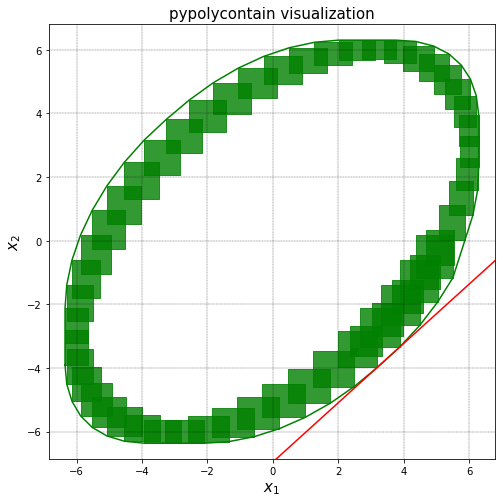

In [14]:
def distance_line_to_point(a, b, point):
    '''
    Calculates the distance between a line and a point in 2D.
    '''
    return abs(a[0]*point[0] + a[1]*point[1] - b) / (a[0]**2 + a[1]**2)**0.5

x_0 = [10, 0]
goal = [0, 0]
a_min = None
b_min = None
d_goal_min = float('inf')
for halfspace in halfspaces:
    a = halfspace[0]
    b = halfspace[1]
    if a[0] * x_0[0] + a[1] * x_0[1] < b:
        continue
    d_goal = distance_line_to_point(a, b, goal)
    if d_goal < d_goal_min:
        d_goal_min = d_goal
        a_min = a
        b_min = b

# print(f"a_min: {a_min}")
# print(f"b_min: {b_min}")
# p = [2, -4]
# print(f"Test point p = {p}: a_min @ p = {a_min[0] * p[0] + a_min[1] * p[1]} <= b_min = {b_min}")
pp.visualize(zts_obj)
plt.plot(x,y,'g')
plt.plot([-7, 7], [(b_min - a_min[0] * (-7)) / a_min[1], (b_min - a_min[0] * (7)) / a_min[1]], 'r')
plt.show()

Let's define our CBF! Remember, the safeset which we would like to render invariant (basically means if we are inside the set, we will remain in the set) is of the form

$\mathcal{C} = \left\{x \in \mathbb{R}^n \mid h\left(x, t\right) \geq 0 \right\}$

where our barrier function $h$ might depend explicitly on time. In our first scenario, however, we generate a constant CBF so there won't be any time dependencies.

In [15]:
h_static = lambda x, t: a_min[0] * x[0] + a_min[1] * x[1] - b_min  # h(x) = a^T @ x - b >= 0

## Control Synthesis!
Now that we've defined our CBF, we need to synthesize control inputs $u$ which render $\mathcal{C}$ invariant. Have a look at the lectures (or the linked paper) again and convince yourself that 

$\dot{h}\left(x, t\right) \geq - \gamma h\left(x, t\right)$

ensures invariance. By applying the chain rule to the above constraint, we can obtain an expression

$\dot{h}(x, t) = \frac{\partial h }{\partial x} \dot{x} + \frac{\partial h}{\partial t} = \frac{\partial h }{\partial x} (Ax + Bu + d) + \frac{\partial h}{\partial t} \geq -\gamma h(x, t)$

which is linear in the control input and, thus, this constraint can be included in convex optimization problems!

Basically, what we want to do now is to develop a safety filter that takes as input a reference control input $u_{ref}$, e.g. the LQR control input, and outputs a safe control input that satisfies the safety constraint. Additionally, this modified control input should be as close as possible to the reference input so that the robot follows its reference controller and the safety filter only intervenes if we're about to violate the safety specification. This can be formulated as an optimization problem

$$
\begin{aligned}
	\min_{u} \quad &(u - u_{ref})^T Q (u - u_{ref})\\
	\textrm{s.t.  } \quad  &\frac{\partial h }{\partial x} (Ax + Bu + d) + \frac{\partial h}{\partial t} \geq - \gamma h(x, t)
    \end{aligned}.
$$

which is a quadratic program (QP) and, thus, can be solved efficiently. For the following simulations simply assume that the robot disturbance is zero, i.e. $d=0$.

In order to solve the optimization problem, we will make use of python convex optimization package `cvxopt`. Please have a look at $\href{https://cvxopt.org/examples/tutorial/qp.html}{this} $ example of how to formulate and solve a QP in python. Hint: formulate the optimization using the decision variable $\tilde{u} = u - u_{ref}$ which requires slight modification of the safety constraint.

In [16]:
# Some imports for the CBF formulation
from scipy.integrate import odeint
from math import sin, cos, sqrt, atan2, pi
from cvxopt import matrix, solvers

Let's define the function of the safety filter!

In [17]:
def safety_filter(x, h, t):
    gamma = 10
    # reference control input
    u_ref = - K @ x  # u = -Kx

    # Barrier condition dhdx * (f(x) + g(x) u) >= -h(x)
    dhdx = np.array(a_min)  # h(x) = a^T @ x - b -> dh/dx = a^T
    dhdt = 0

    # set up QP: (https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf)
    # min 1/2 x^T P x + q^T x -> P = 2*Q, q=0
    # s.t. Gx <= h
    # dh/dx*(Ax+Bu)+dh/dt = dh/dx*(Ax+Bu)+0 = dh/dx*Ax + dh/dx*B*(u_tilde+u_ref) >= -gamma*h(x,t)
    # -> dh/dx*Ax + gamma*h(x,t) + dh/dx*B*u_ref >= -dh/dx*B*u_tilde
    # -> h = dh/dx*Ax + gamma*h(x,t) + dh/dx*B*u_ref, G = -dh/dx*B
    P = 2 * matrix(np.identity(2), tc='d')
    q = matrix(np.zeros(2), tc='d')
    G = matrix(-np.transpose(dhdx) @ B, (1, 2), tc='d')
    h_opt = matrix(np.transpose(dhdx) @ A @ x + gamma * h(x,t) + np.transpose(dhdx) @ B @ u_ref, tc='d')

    solvers.options['show_progress'] = False
    sol = solvers.qp(P,q,G,h_opt)
    u_tilde = np.array([i for i in sol['x']])
    u_safe = u_tilde + u_ref
    return u_safe

Now we're gonna run a simple simulation which should show that the static halfspace constraint is always satisfied. To do so, we need to define the closed loop system and call a differential equation solver!

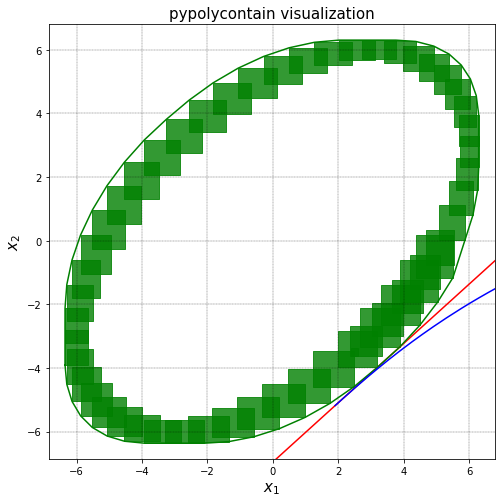

In [18]:
def closed_loop_system(x, t):
    # controller
    u_safe = safety_filter(x, h_static, t)
    dx = A @ x + B @ u_safe
    return dx

# Initial Conditions
t_sim = np.linspace(0, sim_duration, 300)


x_sol = odeint(closed_loop_system, c0, t_sim)

fig, ax = plt.subplots()
pp.visualize(zts_obj, fig=fig, ax=ax)
plt.plot([-7, 7], [(b_min - a_min[0] * (-7)) / a_min[1], (b_min - a_min[0] * (7)) / a_min[1]], 'r')
plt.plot(x,y,'g')
plt.plot(x_sol[:, 0], x_sol[:, 1], 'b')
plt.show()

## Let's see an animated version!
It might take a while to visualize.

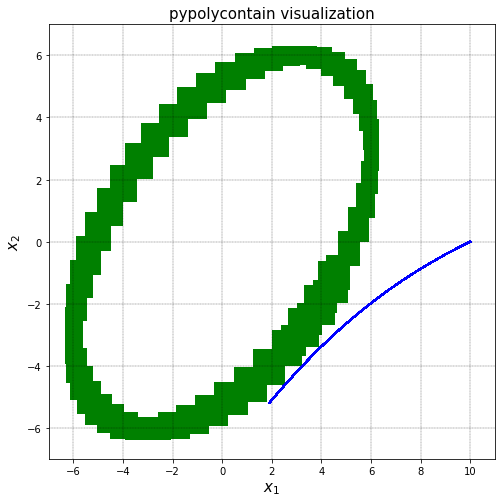

In [19]:
## ANIMATION FUNCTION
def animation_func(i,data):
  current_t = i * (sim_duration / len(t_sim))
  zts_obj = data[0]
  robot_pos = data[1]
  pp.visualize([zts_obj[min(len(zts_obj)-1, int(np.floor(current_t / r)))]], fig=fig, ax=ax)
  plt.plot(robot_pos[0:i, 0], robot_pos[0:i, 1], 'b')
  ax.set_xlim([-7, 11])
  ax.set_ylim([-7, 7])
  
fig = plt.figure()
ax = fig.add_subplot(111)
animation = FuncAnimation(fig,animation_func, fargs=((zts_obj,x_sol),),
                          frames=len(t_sim)-1, interval=50, blit=False)
HTML(animation.to_html5_video())

## Safe? yes! Is it what we want? No..
From this simulation we can observe that the robot indeed stays safe at all time, i.e. it does not collide with the dynamic obstacle. However, it is also rather conservative since the robot stays in the safe halfspace although the obstacle is far away. How can we change that? The key is to consider a timevarying control barrier function that changes whenever the obstacle is moving. In this section we will look into more sophisticated CBFs that will change over time. In this way, we will not only ensure safety but also ensure that our robot reaches its destination!

One requirement of a valid CBF is that it's continuous in time and continuously differentiable with respect to $x$ and $t$. Since we only have the obstacle zonotopes at discrete time steps, we will use a simple linear time interpolation for the obstacle between time steps $t_k$ and $t_{k+1}$.

The following function takes the current time as well as the list of discrete zonotopes and returns a polytope in vertex form (V_polytope) at the current time.

In [20]:
def cont_time_obstacle(t, zonotopes_obst):
  # Required for interpolation: zonotopes at last and next timestep
  ind = int(np.floor(t / r))
  t_last = ind * r
  t_next = (ind + 1) * r
  obst_last = zonotopes_obst[min(ind, len(zts_obj)-1)]
  obst_next = zonotopes_obst[min(ind+1, len(zts_obj)-1)]

  # Linear interpolation of zonotopes
  z_c = obst_last.x + ((obst_next.x - obst_last.x) / (t_next - t_last)) * (t - t_last) # center of zonotope at time t
  z_G = np.append(obst_next.G * (t - t_last) / (t_next - t_last), obst_last.G * (1 - (t - t_last) / (t_next - t_last)), axis=1)
  obst_t = pp.zonotope(x=z_c, G=z_G)

  # Get the vertices from the zonotope
  obst_t = pp.conversions.zonotope_to_V(obst_t)
  return obst_t

cont_time_obstacle(1, zts_obj) # own test

array([[4.76472119, 4.76238697],
       [5.6319688 , 4.76238697],
       [5.6319688 , 5.63845497],
       [4.76472119, 5.63845497]])

Now we have a function to call that provides us with a polytope representation of the obstacle at any time. However, we still need to ensure that our robot is always outside of the polytope. There are different ways to ensure collision avoidance, e.g. taking the distance between a point and a polygon. However, this would be a nonsmooth measure in $x$ which is why we consider an overapproximating circle in the following.

Find the smallest circle that contains the entire polytope at time t!

In [21]:
def bounding_radius(t, zonotopes_obst):
  # Required for interpolation: zonotopes at last and next timestep
  ind = int(np.floor(t / r))
  t_last = ind * r
  t_next = (ind + 1) * r
  obst_last = zonotopes_obst[min(ind, len(zts_obj)-1)]
  obst_next = zonotopes_obst[min(ind+1, len(zts_obj)-1)]

  # Linear interpolation of zonotopes
  z_c = obst_last.x + ((obst_next.x - obst_last.x) / (t_next - t_last)) * (t - t_last) # center of zonotope at time t
  z_G = np.append(obst_next.G * (t - t_last) / (t_next - t_last), obst_last.G * (1 - (t - t_last) / (t_next - t_last)), axis=1)
  obst_t = pp.zonotope(x=z_c, G=z_G)

  # Get the vertices from the zonotope
  obst_vertices = pp.conversions.zonotope_to_V(obst_t)

  # Determine vertice which is furthest away from the center
  dists_squared = np.sum(np.square(obst_vertices - z_c), axis=1)

  # The required radius is equivalent to the max. distance
  r_bound = np.max(dists_squared)**0.5

  return z_c, r_bound


# def bounding_radius(t, zonotopes_obst):
#   # Use simple linear interpolation
#   ind = int(np.floor(t / r))
#   t0 = ind * r
#   t1 = (ind+1) * r
  
#   # Zonotope centers
#   z_c0 = zonotopes_obst[min(ind, len(zts_obj)-1)].x
#   z_c1 = zonotopes_obst[min(ind+1, len(zts_obj)-1)].x


#   # center of zonotope at time t
#   z_c = z_c0 + ((z_c1 - z_c0) / (t1 - t0)) * (t - t0)

#   r_bound = 

#   return z_c, r_bound

# TEST
print(bounding_radius(1, zts_obj))

(array([5.198345  , 5.20042097]), 0.6163630308971679)


Let's check if our bounding circle algorithm works properly!

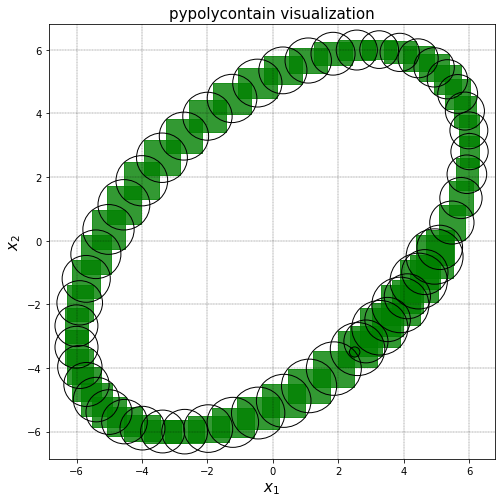

In [22]:
from matplotlib.patches import Circle

fig, ax = plt.subplots()
pp.visualize(zts_obj, fig=fig, ax=ax)
for i in range(len(zts_obj)):
  tnow = i * r
  center, radius = bounding_radius(tnow, zts_obj)
  ax.add_artist(Circle(center, radius, fill=False))
plt.show()

In the case of a CBF that explicitly depends on time, we need to to account for the known change of the obstacle over time. In this case, the explicit CBF time derivative $\frac{\partial h}{\partial t}$ is nonzero.

However, since the explicit time dependency is not exactly known in our case (as a result of discrete reachibility analysis and time interpolation), we approximate the time derivative of the barrier function using finite differences. To be specific, we will use a simple forward difference method

$\frac{\partial f}{\partial t} (t) \approx \frac{f\left(t + \delta t\right) - f\left(t\right)}{\delta t}$.

The CBF we consider is given as

$h(x, t) = \lVert x - c_{obs}(t) \rVert_2 - r_{obs}(t) \geq 0$

In the following, write a function that returns the value of the CBF $h(x, t)$, its gradient $\frac{\partial h}{\partial x}$ as well as its explicit time derivative $\frac{\partial h}{\partial t}$. Hint: you need to apply the chain rule for the gradient and the time derivative. Approximate explicit time derivatives $\frac{\partial c_{obs}}{\partial t}$ and $\frac{\partial r_{obs}}{\partial t}$ using finite differences.

Notes by Franz: <br />
$h(x, t) = \lVert x - c_{obs}(t) \rVert_2 - r_{obs}(t) = \sqrt{(x_0 - c_{obs,0}(t))^2 + (x_1 - c_{obs,1}(t))^2} - r_{obs}(t) \geq 0$ <br />
$\dot{h}(x, t) = \frac{\partial h }{\partial x} \dot{x} + \frac{\partial h}{\partial t} = \frac{\partial h }{\partial x} (Ax + Bu + d) + \frac{\partial h}{\partial t} \geq -\gamma h(x, t)$ <br />
$\frac{\partial h }{\partial x} = \frac{2(x - c_{obs}(t))}{2 \lVert x - c_{obs}(t) \rVert_2} = (x - c_{obs}(t)) \cdot \lVert x - c_{obs}(t) \rVert_2^{-1}$ <br />
$\frac{\partial h }{\partial t} = \frac{2(c_{obs}(t) - x)}{2 \lVert x - c_{obs}(t) \rVert_2} \dot{c}_{obs}(t) - \dot{r}_{obs}(t) = (c_{obs}(t) - x) \cdot \lVert x - c_{obs}(t) \rVert_2^{-1} \cdot \frac{\partial c_{obs}(t)}{\partial t} - \frac{\partial r_{obs}(t)}{\partial t}$

In [23]:
def cbf_dynamic(x, t):
  # Input: state defined as x = [x_robot, y_robot]
  # Output: Value of CBF h(x), gradient with respect to x dhdx(x), explicit time derivative dhdt

  c_obs, r_obs = bounding_radius(t, zts_obj) # values for timestep t
  dist_c2c = np.linalg.norm(x - c_obs) # distance center to center
  h_val = dist_c2c - r_obs
  dhdx = (x - c_obs) * dist_c2c**(-1)

  dt = 0.075
  c_obs_dt, r_obs_dt = bounding_radius(t+dt, zts_obj) # values for timestep t+dt
  dcdt = (c_obs_dt - c_obs) / dt
  drdt = (r_obs_dt - r_obs) / dt
  dhdt = (c_obs - x) * dist_c2c**(-1) @ dcdt - drdt

  return h_val, dhdx, dhdt

#Test
print(cbf_dynamic(c0, 0))

(8.116878662444872, array([0.90618314, 0.42288547]), -12.901925657765926)


Now, we will define the safety filter similarly to the safety filter using the static CBF. Set up the QP and run the continuous time simulation. What can you observe? Try different parameter settings for $\gamma = [1, 10, 30]$. Also, plot the value of $h(x, t)$ over time for different values of $\gamma$. What is the trade-off when choosing large values of $\gamma$?

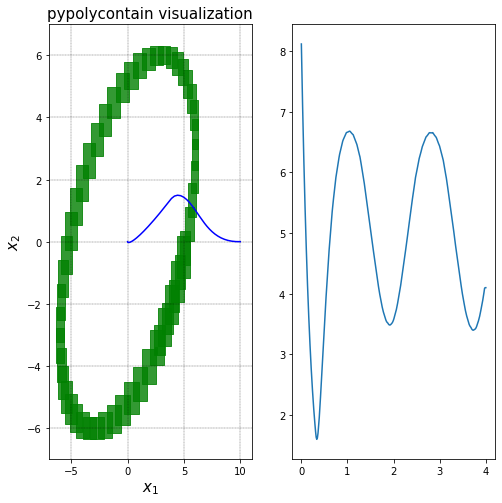

In [24]:
def safety_filter(x, t):
    #PUT YOUR CODE HERE
    gamma = 5
    # reference control input
    u_ref = - K @ x  # u = -Kx

    # Barrier condition dh/dx*(Ax+Bu)+dh/dt >= -gamma*h(x,t)
    h_val, dhdx, dhdt = cbf_dynamic(x, t)

    # set up QP: (https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf)
    # min 1/2 x^T P x + q^T x -> P = 2 Q, q=0
    # s.t. Gx <= h_opt
    # dh/dx * (Ax + Bu) + dh/dt = dh/dx * Ax + dh/dx * B * (u_tilde + u_ref) + dh/dt >= -gamma * h(x,t)
    # -> dh/dx * Ax + gamma * h(x,t) + dh/dx * B * u_ref + dh/dt >= -dh/dx * B * u_tilde
    # -> h_opt = dh/dx * Ax + gamma * h(x,t) + dh/dx * B * u_ref + dh/dt, G = -dh/dx*B
    P = 2 * matrix(np.identity(2), tc='d')
    q = matrix(np.zeros(2), tc='d')
    G = matrix(-np.transpose(dhdx) @ B, (1, 2), tc='d')
    h_opt = matrix(np.transpose(dhdx) @ A @ x + gamma * h_val + np.transpose(dhdx) @ B @ u_ref + dhdt, tc='d')

    solvers.options['show_progress'] = False
    sol = solvers.qp(P,q,G,h_opt)
    u_tilde = np.array([i for i in sol['x']])
    u_safe = u_tilde + u_ref
    return u_safe

# closed loop dynamics including CBF controller
def closed_loop_system(x, t):
    #PUT YOUR CODE HERE
    u_safe = safety_filter(x, t)
    dx = A @ x + B @ u_safe
    return dx

# Initial Conditions
t_sim = np.linspace(0, sim_duration, 300)

x_sol = odeint(closed_loop_system, c0, t_sim)

fig = plt.figure() 
ax = fig.add_subplot(121)
pp.visualize(zts_obj, fig=fig, ax=ax)
plt.plot(x_sol[:, 0], x_sol[:, 1], 'b')
ax.set_xlim([-7, 11])
ax.set_ylim([-7, 7])
ax2 = fig.add_subplot(122)
plt.plot(t_sim, [cbf_dynamic(x_sol[i], t_sim[i])[0] for i in range(len(t_sim))])
plt.show()

Answer to "What is the trade-off when choosing large values of $\gamma$?": <br />
With larger values for $\gamma$ the robot keeps a larger distance to the object. However, that also result in a larger path length or that the goal cannot be reached at all.

Lastly, we can see our robot in action! In this simulation section, you have been working on safe control synthesis in a reactive setting meaning that obstacle avoidance is guaranteed but it also could have been avoided at all if this problem would have been tackled at a higher level such as motion planning. Nonetheless, CBFs are an amazing tool for safety guarantees on a control level. There are many different topics that you could explore from here, e.g. robust CBFs, CBFs under uncertainties, CBFs for multi-agent systems, CBFs for safe reinforcement learning and many more!

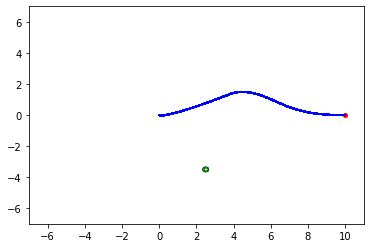

In [25]:
## ANIMATION FUNCTION
def animation_func(i,data):
  # visualize robot 
  robot_pos = data
  plt.plot([robot_pos[k][0] for k in range(i)], [robot_pos[k][1] for k in range(i)], 'b')
  
  current_t = i * (sim_duration / len(t_sim))
  
  # visualize obstacle set
  current_obs = cont_time_obstacle(current_t, zts_obj)
  conv_hull_obj = MultiPoint(current_obs).convex_hull
  x,y = conv_hull_obj.exterior.coords.xy
  poly_plot.set_xdata(x)
  poly_plot.set_ydata(y)

  c_obs, r_obs = bounding_radius(current_t, zts_obj)
  patch.center = c_obs
  patch.radius = r_obs

  ax.set_xlim([-7, 11])
  ax.set_ylim([-7, 7])
  
fig = plt.figure()
ax = fig.add_subplot(111)
conv_hull_obj = MultiPoint(cont_time_obstacle(0, zts_obj)).convex_hull
x,y = conv_hull_obj.exterior.coords.xy
poly_plot, = plt.plot(x, y, 'g')
plt.plot([c0[0]], [c0[1]], marker='o', markersize=4, c='r')

# Visualize circle
c_obs, r_obs = bounding_radius(0, zts_obj)
patch = Circle(c_obs, r_obs, fill=False)
ax.add_artist(patch)


animation = FuncAnimation(fig,animation_func, fargs=((x_sol),),
                          frames=len(x_sol), interval=50, blit=False)
HTML(animation.to_html5_video())